In [10]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from processing_func import check_coords, calc_N2_kappa, calc_hab, arctic_calchab
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [64]:
arctic_mix = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/arctic_mix.nc"
ABSO_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/alberto_ds.nc"
global_pkl = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/input_microstructure.pkl"
global_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"
mosaic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/mosaic_ds.nc"
nice_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/nice_ds.nc"
HM_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/processed_data/HM_ds.nc"
NN_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/L2_2D_snapshot_iy150_model_input.nc"

arctic_ds = xr.open_dataset(arctic_mix)
ABSO_ds = xr.open_dataset(ABSO_nc)
global_ds = pd.read_pickle(global_pkl)
global_nn = xr.open_dataset(global_nc)
mosaic_ds = xr.open_dataset(mosaic_nc)
nice_ds = xr.open_dataset(nice_nc)
HM_ds = xr.open_dataset(HM_nc)
NN_ds = xr.open_dataset(NN_nc)

## write algorithm myself

In [74]:
def mld(dataset, outfile, save_mld):
    """
    out = mld(dataset, outfile, save_mld)

    Reads:
        dataset   :: xarray dataset containing rho, drhodz, and d2rhodz2 variables
        outfile   :: output file to save the snapshot of the computed MLD
        save_mld  :: if True, the computed MLD will be saved in the output file

    Returns:
        MLDI, MLDJ :: xarray DataArrays representing the MLD indices and values
    """
    dataset["rho"] = gsw.rho(dataset["S"], dataset["T"], 0)
    dataset['drhodz'] = dataset.rho.differentiate('depth')
    dataset['d2rhodz2'] = dataset.drhodz.differentiate('depth')

    # Extract variables from the dataset
    rho = dataset["rho"]
    drhodz = dataset["drhodz"]
    d2rhodz2 = dataset["d2rhodz2"]

    # Extract dimensions from the dataset
    depth_size, profile_size = rho.shape

    MLDI = np.ones((profile_size,)) * np.nan
    MLDJ = np.ones((profile_size,)) * np.nan

    for profile_num in range(profile_size):
        tmp = drhodz[:, profile_num, ]
        tmp2 = d2rhodz2[:, profile_num]

        if np.isnan(tmp).all():
            continue

        # Find the index of minimum stratification
        I = np.nanargmin(tmp)
        MLDI[profile_num] = I

        if I > 2:
            # Check for non-NaN values in the slice
            valid_slice = tmp2[:I][~np.isnan(tmp2[:I])]
            if len(valid_slice) > 0:
                J = np.nanargmax(valid_slice)
                I = min(I, J)

        if tmp2[I] < 0. and (I > 4 and I == J):
            MLDJ[profile_num] = 0
        else:
            MLDJ[profile_num] = I

    if save_mld:
        # Save the MLD
        MLD_dataset = xr.Dataset({"MLDI": (("profile",), MLDI), "MLDJ": (("profile",), MLDJ)})
        MLD_dataset.to_netcdf(outfile)

    MLDI = xr.DataArray(MLDI, dims=("profile",), coords={"profile": range(profile_size)})
    MLDJ = xr.DataArray(MLDJ, dims=("profile",), coords={"profile": range(profile_size)})

    dataset["MLDI"] = MLDI
    dataset["MLDJ"] = MLDJ
    
    return dataset


(440, 1684)
(1684,)


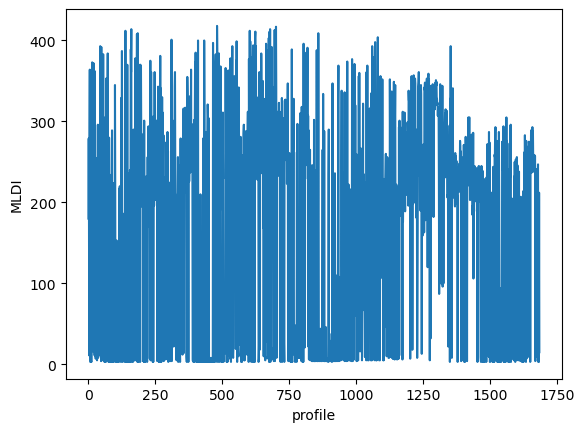

In [70]:
outfile = "mld_output.nc"
# Specify whether to save the MLD or not
save_mld = False
mosaic_ds = mld(mosaic_ds, outfile, save_mld)
mosaic_ds.MLDI.plot()

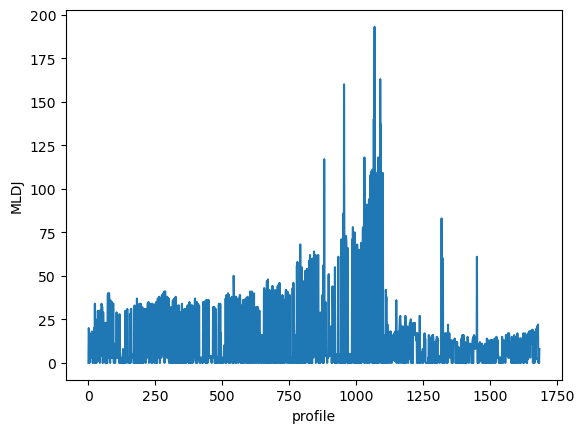

In [72]:
mosaic_ds.MLDJ.plot()

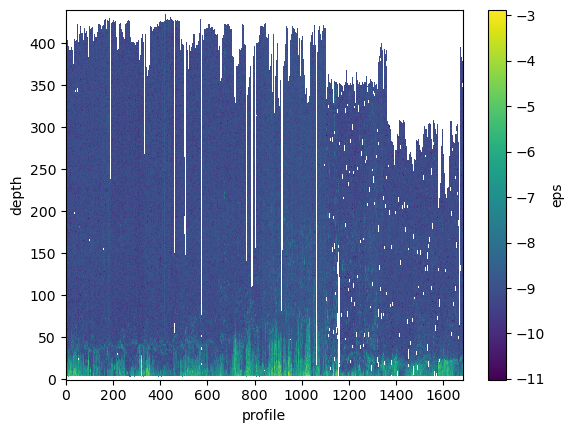

In [73]:
mosaic_ds.eps.plot()

# TRY for all datasets

In [78]:
arctic_mld = mld(arctic_ds, outfile, save_mld)

In [79]:
ABSO_mld = mld(ABSO_ds, outfile, save_mld)

In [89]:
HM_mld = mld(HM_ds, outfile, save_mld)

In [84]:
NICE_mld = mld(nice_ds, outfile, save_mld)

In [97]:
def mld(dataset, outfile=None, save_mld=False):
    """
    out = mld(dataset, outfile, save_mld)

    Reads:
        dataset   :: xarray dataset containing rho, drhodz, and d2rhodz2 variables
        outfile   :: output file to save the snapshot of the computed MLD
        save_mld  :: if True, the computed MLD will be saved in the output file

    Returns:
        MLDI, MLDJ :: xarray DataArrays representing the MLD indices and values
    """
    dataset["rho"] = gsw.rho(dataset["S"], dataset["T"], 0)
    dataset['drhodz'] = dataset.rho.differentiate('depth')
    dataset['d2rhodz2'] = dataset.drhodz.differentiate('depth')

    # Extract variables from the dataset
    rho = dataset["rho"]
    drhodz = dataset["drhodz"]
    d2rhodz2 = dataset["d2rhodz2"]

    # Extract dimensions from the dataset
    depth_size, profile_size = rho.shape

    MLDI = np.ones((profile_size,)) * np.nan
    MLDJ = np.ones((profile_size,)) * np.nan

    for profile_num in range(profile_size):
        tmp = drhodz[:, profile_num, ]
        tmp2 = d2rhodz2[:, profile_num]

        if np.isnan(tmp).all():
            continue

        # Find the index of minimum stratification
        I = np.nanargmin(tmp)
        MLDI[profile_num] = I

        if I > 2:
            # Check for non-NaN values in the slice
            valid_slice = tmp2[:I][~np.isnan(tmp2[:I])]
            if len(valid_slice) > 0:
                J = np.nanargmax(valid_slice)
                I = min(I, J)

        if tmp2[I] < 0. and (I > 4 and I == J):
            MLDJ[profile_num] = 0
        else:
            MLDJ[profile_num] = I

    if save_mld:
        # Save the MLD
        MLD_dataset = xr.Dataset({"MLDI": (("profile",), MLDI), "MLDJ": (("profile",), MLDJ)})
        MLD_dataset.to_netcdf(outfile)

    MLDI = xr.DataArray(MLDI, dims=("profile",), coords={"profile": range(profile_size)})
    MLDJ = xr.DataArray(MLDJ, dims=("profile",), coords={"profile": range(profile_size)})

    dataset["MLDI"] = MLDI
    dataset["MLDJ"] = MLDJ
    
    return dataset


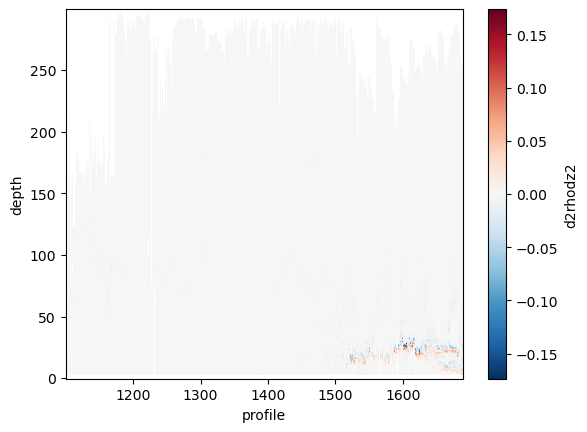

In [94]:
NICE_mld.d2rhodz2.plot()

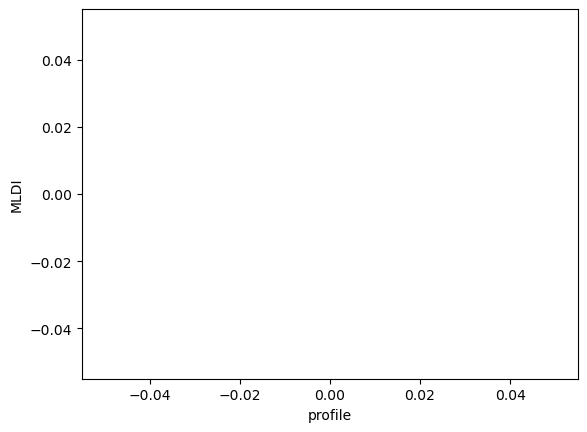

In [95]:
NICE_mld.MLDI.plot()

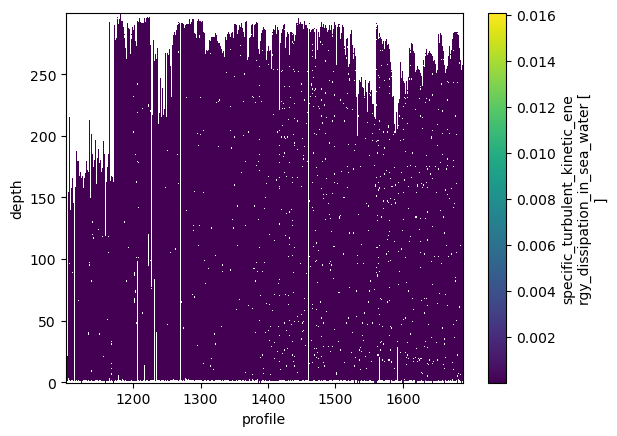

In [87]:
NICE_mld.eps.plot()